DEPRECATED!!!!!! as phrase and ngram will be in one giant notebook

Grid Search Analysis
===

Concept type: `PHRASE`
---

Compares the results of the grid search per dataset. And spits out the best one...


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib import cm


import json
import codecs
import os
from os import path

In [2]:
basepath = os.path.normpath("C:\\Users\\hatieke\\.ukpsummarizer\\results\\grid_search\\concept-type-phrases")

In [3]:
dirs = [f for f in os.listdir(basepath) if os.path.isdir(os.path.normpath(os.path.join(basepath, f)))]

In [4]:
dirs

['9623ef172d38f5006cb0633b0fcbbbdcbc233ec98b38fbad9db02eef']

In [5]:
selected = dirs[0]
selected

'9623ef172d38f5006cb0633b0fcbbbdcbc233ec98b38fbad9db02eef'

In [6]:
def parse_dir(dir):
    p = os.path.join(basepath, dir)
    result_jsons = []
    result_files = [f for f in os.listdir(p) if f.startswith("result-") and f.endswith(".json")]
    for f in result_files:
        fn = os.path.join(p, f)
        fsize = os.path.getsize(fn)
        if fsize > 0:
            with open(fn) as fp:
                result_jsons.append(json.load(fp))
    return result_jsons

In [7]:
def parse_single_result_into_dataframe(obj, iteration=11):
    config = obj[u'config_feedbackstore']
    try:
        res = [i for i in obj["result_rougescores"] if i["iteration"] <= iteration][-1]
    except:
        raise BaseException("unknown iteration %s" % (obj["config_run_id"]))
    
    total_accept = sum([1 for i in obj[u'log_feedbacks'] if i["value"] == 'accept' and i["iteration"] < iteration])
    total_reject = sum([1 for i in obj[u'log_feedbacks'] if i["value"] != 'accept' and i["iteration"] < iteration])
    total_feedback = total_accept + total_reject
    
    num_iterations = res["iteration"]
    r1 =  res[u'ROUGE-1 R score']
    r2 =  res[u'ROUGE-2 R score']
    r4 =  res[u'ROUGE-SU* R score']
   
    classtype = config.get(u'type')
    cut_off_threshold = config.get(u'cut_off_threshold')
    iterations_accept = config.get(u'iterations_accept')
    iterations_reject = config.get(u'iterations_reject')
    propagation_abort_threshold = config.get(u'propagation_abort_threshold')
    mass_accept = config.get(u'mass_accept')
    mass_reject = config.get(u'mass_reject')
    window_size = config.get(u'N')
    factor_reject = config.get(u"multiplier_reject")
    factor_accept = config.get(u"multiplier_accept")
    cutoff = config.get(u"cut_off_threshold", config.get("cutoff_threshold"))

    runid = obj.get("config_run_id")
    word2vec = obj.get("config_wordembeddings")
    
    parse_type = obj.get("config_parse_type")
    if parse_type is None or parse_type.lower() is "None".lower():
        parse_type = "ngrams"
        
    oracle_type = obj.get("config_oracle_type", "accept")
      
    ub = obj.get("model_rougescores", {})
    ub_r1 = ub.get("ROUGE-1 R score", -1)
    ub_r2 = ub.get("ROUGE-2 R score", -1)
    ub_r4 = ub.get("ROUGE-SU* R score", -1)
    
    return {
        "accept" : total_accept,
        "reject": total_reject,
        "total_feedback": total_feedback,
        "ref_summary": str([item["name"] for item in obj[u'models']]),
        "cfg": json.dumps(config),
        "num_iterations": num_iterations,
        "r1": r1,
        "r2": r2,
        "r4": r4,
        "classtype": classtype,
        "iterations_accept":iterations_accept,
        "iterations_reject": iterations_reject,
        "propagation_abort_threshold": propagation_abort_threshold,
        "mass_accept" : mass_accept,
        "mass_reject" : mass_reject,
        "window_size": window_size,
        "multiplier_reject": factor_reject,
        "multiplier_accept": factor_accept,
        "cutoff_threshold": cutoff,
        "run_id": runid,
        "ub_r1": ub_r1,
        "ub_r2": ub_r2,
        "ub_r4": ub_r4,
        "phrase_type": parse_type,
        "embeddings": word2vec,
        "size": 100,
        "max_iteration_count": 10
    }


In [8]:
#parse_single_result_into_dataframe(first, iteration=10)

In [9]:
#items = [parse_single_result_into_dataframe(f, iteration=11) for d in dirs for f in parse_dir(d)]
items = [parse_single_result_into_dataframe(f, iteration=11) for f in parse_dir(selected)]

In [10]:
len(items)

35528

In [11]:
#items[0]

In [12]:
df = pd.DataFrame(items)

In [13]:
# convert pojo into string
#df["cfg"] = df.apply(lambda x: json.dumps(x["cfg"]), axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35528 entries, 0 to 35527
Data columns (total 27 columns):
accept                         35528 non-null int64
cfg                            35528 non-null object
classtype                      35528 non-null object
cutoff_threshold               34500 non-null float64
embeddings                     35528 non-null object
iterations_accept              34500 non-null float64
iterations_reject              34500 non-null float64
mass_accept                    34500 non-null float64
mass_reject                    34500 non-null float64
max_iteration_count            35528 non-null int64
multiplier_accept              1024 non-null float64
multiplier_reject              1024 non-null float64
num_iterations                 35528 non-null int64
phrase_type                    35528 non-null object
propagation_abort_threshold    27000 non-null float64
r1                             35528 non-null float64
r2                             35528 no

In [15]:
# throw away implausible results
df = df.loc[df.r2 >0].loc[df.r1 > 0].loc[df.r4 >0]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32702 entries, 0 to 35527
Data columns (total 27 columns):
accept                         32702 non-null int64
cfg                            32702 non-null object
classtype                      32702 non-null object
cutoff_threshold               31674 non-null float64
embeddings                     32702 non-null object
iterations_accept              31674 non-null float64
iterations_reject              31674 non-null float64
mass_accept                    31674 non-null float64
mass_reject                    31674 non-null float64
max_iteration_count            32702 non-null int64
multiplier_accept              1024 non-null float64
multiplier_reject              1024 non-null float64
num_iterations                 32702 non-null int64
phrase_type                    32702 non-null object
propagation_abort_threshold    26979 non-null float64
r1                             32702 non-null float64
r2                             32702 no

In [18]:
df[u'phrase_type'].describe()

count     32702
unique        1
top        None
freq      32702
Name: phrase_type, dtype: object

Construction of a dataframe that fits the analysis needs
===

unabhängige Variablen, also Steuervariablen kann ich festlegen, die den Ausgang der Messung beeinflussen (in unbekannter Art). Im Dataframe sind das folgende Spalten:

* classtype
* cutoff_threshold
* iterations_accept
* iterations_reject
* mass_accept
* mass_reject
* multiplier_accept
* multiplier_reject
* propagation_abort_threshold
* ref_summary
* window_size

Und folgende sind die abhängigen Variablen, also die Messvariablen, die quasi die Manifestation der Effekte. 

* accept
* num_iterations
* r1
* r2
* r4
* reject
* total_feedback

Es soll untersucht werden, welche Kombinationen unabhängiger Variablen die besten sind, also die baseline am weitesten übertreffen.

Dazu muss in jeder ref_summary-gruppe der wert der "baseline r2" als extra feld hinzugefügt werden und auch die differenz

Aus Rouge-2 baseline neue Spalten ableiten: als Delta und als Ratio 
---

In [19]:
# find all baselines
baselines = df.classtype.str.contains("Baseline")

# throw away uninteresting columns
baseline_scores = df.loc[baselines].loc[:,["ref_summary","accept", "reject","r2"]]

# rename important columns
baseline_scores.rename(columns={"r2":"r2bl", "accept": "acceptbl", "reject":"rejectbl"}, inplace=True)

In [20]:
# merge df and baseline_scores, so that the r2bl score is now available in every run.
df = pd.merge(df, baseline_scores, on="ref_summary")

In [21]:
# add the delta of baseline and actual r2 as separate column
df["delta_r2bl_r2"] = df["r2bl"] - df["r2"]
df["ratio_r2bl_r2"] = df["r2"] / df["r2bl"]

In [22]:
# add the delta and ratio of the upper bound r2 as separate columns:
df["delta_r2ub"] = df["ub_r2"] - df["r2"]
df["ratio_r2ub"] = df["r2"] / df["ub_r2"]
df["ratio_r2ub_vs_feedback"] = df["ratio_r2ub"] / df["total_feedback"]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32702 entries, 0 to 32701
Data columns (total 35 columns):
accept                         32702 non-null int64
cfg                            32702 non-null object
classtype                      32702 non-null object
cutoff_threshold               31674 non-null float64
embeddings                     32702 non-null object
iterations_accept              31674 non-null float64
iterations_reject              31674 non-null float64
mass_accept                    31674 non-null float64
mass_reject                    31674 non-null float64
max_iteration_count            32702 non-null int64
multiplier_accept              1024 non-null float64
multiplier_reject              1024 non-null float64
num_iterations                 32702 non-null int64
phrase_type                    32702 non-null object
propagation_abort_threshold    26979 non-null float64
r1                             32702 non-null float64
r2                             32702 no

statistics comparing against the upper bound (!)
===

The analysis below should give an idea, which independent variables have an influence onto the result. For example, `multiplier_accept` seems to have a positive influence (higher accept multiplier results in higher score). However, A score of 0.6 is not awesome, as it is still below 1.0

The analysis is done per method. I.e. In 4 blocks.


In [1]:
# the variable we want to analyse
dep_var = "ratio_r2ub"

In [ ]:
# the variable we want to analyse
dep_var = "ratio_r2ub_vs_feedback"

What classtypes are there? And how many of each?

In [26]:
df.groupby("classtype").count()

,accept,cfg,cutoff_threshold,embeddings,iterations_accept,iterations_reject,mass_accept,mass_reject,max_iteration_count,multiplier_accept,...,ub_r4,window_size,acceptbl,rejectbl,r2bl,delta_r2bl_r2,ratio_r2bl_r2,delta_r2ub,ratio_r2ub,ratio_r2ub_vs_feedback
classtype,,,,,,,,,,,,,,,,,,,,,
BaselineFeedbackStore,4,4,0,4,0,0,0,0,4,0,...,4,0,4,4,4,4,4,4,4,4
SimpleNgramFeedbackGraph,1024,1024,0,1024,0,0,0,0,1024,1024,...,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024
WordEmbeddingGaussianFeedbackGraph,4695,4695,4695,4695,4695,4695,4695,4695,4695,0,...,4695,0,4695,4695,4695,4695,4695,4695,4695,4695
WordEmbeddingRandomWalkDiffusionFeedbackGraph,26979,26979,26979,26979,26979,26979,26979,26979,26979,0,...,26979,0,26979,26979,26979,26979,26979,26979,26979,26979


In [27]:
df.groupby("phrase_type").count()

,accept,cfg,classtype,cutoff_threshold,embeddings,iterations_accept,iterations_reject,mass_accept,mass_reject,max_iteration_count,...,ub_r4,window_size,acceptbl,rejectbl,r2bl,delta_r2bl_r2,ratio_r2bl_r2,delta_r2ub,ratio_r2ub,ratio_r2ub_vs_feedback
phrase_type,,,,,,,,,,,,,,,,,,,,,
None,32702,32702,32702,31674,32702,31674,31674,31674,31674,32702,...,32702,1024,32702,32702,32702,32702,32702,32702,32702,32702


In [28]:
# draw a boxplot
def bp(data, col, dep_var, grouping = None, classtype=""):
    try:
        if grouping is "groupby":
            data.loc[:,[col,  dep_var, "ref_summary"]].groupby("ref_summary").boxplot(by=col, figsize=(16,4), layout=(2,4), rot=45, fontsize="8", showmeans=True, meanline=True, sym="+", vert=True)
        elif grouping is None:
            data.loc[:,[col,  dep_var, "ref_summary"]].boxplot(by=col, figsize=(10,4), showmeans=True, meanline=True, sym="+", vert=True)
        elif grouping is "line":
            data.loc[:,[col,  dep_var, "ref_summary"]].groupby(col).agg([np.min, np.mean, np.median, np.max]).plot(marker="o")

        #delta2.boxplot(by=col, figsize=(10,4), showmeans=True, meanline=True, sym="+", vert=True)
        plt.savefig(path.join(basepath, "%s-%s-%s-per-summary-%s.pdf" % (grouping, classtype, dep_var,col)))
        plt.show()
        plt.close()
    except:
        print "problem while plotting ", col, dep_var
        plt.close()


Best config, first try
====

best configuration as per agreement between all summaries of same config

we group by configuration, and then use the average ratio_ub2 score as performance measure.

In [29]:
df.groupby(["classtype", "ref_summary"]).mean().sort_values("ratio_r2ub", ascending=False)

accept  \
classtype                                     ref_summary                        
WordEmbeddingRandomWalkDiffusionFeedbackGraph [u'D30044.M.100.T.B']  20.871006   
                                              [u'D30044.M.100.T.C']  26.890222   
                                              [u'D30044.M.100.T.D']  26.691259   
                                              [u'D30044.M.100.T.G']  25.523556   
SimpleNgramFeedbackGraph                      [u'D30044.M.100.T.B']  14.585938   
BaselineFeedbackStore                         [u'D30044.M.100.T.D']  14.000000   
                                              [u'D30044.M.100.T.B']   7.000000   
SimpleNgramFeedbackGraph                      [u'D30044.M.100.T.G']  16.382812   
                                              [u'D30044.M.100.T.D']  20.218750   
BaselineFeedbackStore                         [u'D30044.M.100.T.G']  12.000000   
WordEmbeddingGaussianFeedbackGraph            [u'D30044.M.100.T.B']  15.518617   
SimpleNgramFeedbackGraph                      [u'D30044.M.100.T.C']  16.859375   
WordEmbeddingGaussianFeedbackGraph            [u'D30044.M.100.T.D']  20.632129   
                                              [u'D30044.M.100.T.G']  18.026337   
BaselineFeedbackStore                         [u'D30044.M.100.T.C']   9.000000   
WordEmbeddingGaussianFeedbackGraph            [u'D30044.M.100.T.C']  17.981933   

                                                                     cutoff_threshold  \
classtype                                     ref_summary                               
WordEmbeddingRandomWalkDiffusionFeedbackGraph [u'D30044.M.100.T.B']          0.776416   
                                              [u'D30044.M.100.T.C']          0.775600   
                                              [u'D30044.M.100.T.D']          0.775600   
                                              [u'D30044.M.100.T.G']          0.775600   
SimpleNgramFeedbackGraph                      [u'D30044.M.100.T.B']               NaN   
BaselineFeedbackStore                         [u'D30044.M.100.T.D']               NaN   
                                              [u'D30044.M.100.T.B']               NaN   
SimpleNgramFeedbackGraph                      [u'D30044.M.100.T.G']               NaN   
                                              [u'D30044.M.100.T.D']               NaN   
BaselineFeedbackStore                         [u'D30044.M.100.T.G']               NaN   
WordEmbeddingGaussianFeedbackGraph            [u'D30044.M.100.T.B']          0.825798   
SimpleNgramFeedbackGraph                      [u'D30044.M.100.T.C']               NaN   
WordEmbeddingGaussianFeedbackGraph            [u'D30044.M.100.T.D']          0.815446   
                                              [u'D30044.M.100.T.G']          0.825432   
BaselineFeedbackStore                         [u'D30044.M.100.T.C']               NaN   
WordEmbeddingGaussianFeedbackGraph            [u'D30044.M.100.T.C']          0.821978   

                                                                     iterations_accept  \
classtype                                     ref_summary                                
WordEmbeddingRandomWalkDiffusionFeedbackGraph [u'D30044.M.100.T.B']        3721.734582   
                                              [u'D30044.M.100.T.C']        3717.333333   
                                              [u'D30044.M.100.T.D']        3717.333333   
                                              [u'D30044.M.100.T.G']        3717.333333   
SimpleNgramFeedbackGraph                      [u'D30044.M.100.T.B']                NaN   
BaselineFeedbackStore                         [u'D30044.M.100.T.D']                NaN   
                                              [u'D30044.M.100.T.B']                NaN   
SimpleNgramFeedbackGraph                      [u'D30044.M.100.T.G']                NaN   
                                              [u'D30044.M.100.T.D']                NaN   
Ba

In [30]:
top = df.loc[df["num_iterations"]>1]\
    .loc[df.delta_r2bl_r2<0]\
    .loc[:, ["cfg", dep_var]]\
    .groupby("cfg")\
    .mean()\
    .sort_values(dep_var, ascending=False)

In [31]:
top.head()

,ratio_r2ub
cfg,
"{""mass_reject"": -1.0, ""iterations_accept"": 10000, ""propagation_abort_threshold"": 0.01, ""mass_accept"": -1.0, ""cut_off_threshold"": 0.4, ""type"": ""WordEmbeddingRandomWalkDiffusionFeedbackGraph"", ""iterations_reject"": 200}",1.08186
"{""mass_reject"": -1.0, ""iterations_accept"": 128, ""propagation_abort_threshold"": 0.1, ""mass_accept"": 4.0, ""cut_off_threshold"": 0.6, ""type"": ""WordEmbeddingRandomWalkDiffusionFeedbackGraph"", ""iterations_reject"": 5000}",1.08186
"{""mass_reject"": -1.0, ""iterations_accept"": 128, ""propagation_abort_threshold"": 0.25, ""mass_accept"": -1.0, ""cut_off_threshold"": 0.6, ""type"": ""WordEmbeddingRandomWalkDiffusionFeedbackGraph"", ""iterations_reject"": 200}",1.08186
"{""mass_reject"": -1.0, ""iterations_accept"": 1024, ""propagation_abort_threshold"": 0.01, ""mass_accept"": 1.0, ""cut_off_threshold"": 0.6, ""type"": ""WordEmbeddingRandomWalkDiffusionFeedbackGraph"", ""iterations_reject"": 64}",1.08186
"{""mass_reject"": -1.0, ""iterations_accept"": 1024, ""propagation_abort_threshold"": 0.01, ""mass_accept"": 1.0, ""cut_off_threshold"": 0.6, ""type"": ""WordEmbeddingRandomWalkDiffusionFeedbackGraph"", ""iterations_reject"": 5000}",1.08186


In [32]:
cfg_of_winner = top.reset_index().iloc[0].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), ["classtype","ratio_r2ub", "r2", "ref_summary", "accept", "reject", "total_feedback","num_iterations","run_id"]]

{"mass_reject": -1.0, "iterations_accept": 10000, "propagation_abort_threshold": 0.01, "mass_accept": -1.0, "cut_off_threshold": 0.4, "type": "WordEmbeddingRandomWalkDiffusionFeedbackGraph", "iterations_reject": 200}


,classtype,ratio_r2ub,r2,ref_summary,accept,reject,total_feedback,num_iterations,run_id
2283,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.22772,[u'D30044.M.100.T.D'],24,218,242,4,474a24da259d936093ed0ba852edfab62edb61709bc282...
11240,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.285766,0.17822,[u'D30044.M.100.T.B'],18,263,281,3,5c99f9d137e45a389733338913b9c60815305582e4d0dd...
18277,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.041673,0.26596,[u'D30044.M.100.T.C'],25,298,323,7,3d27a6d14b09b599c2629dc49a910f3dda827c6103fa32...
31018,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.23232,[u'D30044.M.100.T.G'],24,327,351,7,cbd9809603aae8304460c90e497521a5bad34831c96744...


In [33]:
cfg_of_winner = top.reset_index().iloc[1].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), ["classtype","ratio_r2ub", "r2", "ref_summary", "accept", "reject", "total_feedback","num_iterations","run_id"]]

{"mass_reject": -1.0, "iterations_accept": 128, "propagation_abort_threshold": 0.1, "mass_accept": 4.0, "cut_off_threshold": 0.6, "type": "WordEmbeddingRandomWalkDiffusionFeedbackGraph", "iterations_reject": 5000}


,classtype,ratio_r2ub,r2,ref_summary,accept,reject,total_feedback,num_iterations,run_id
519,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.22772,[u'D30044.M.100.T.D'],24,204,228,3,10657e14d55bb09774cb7bcf5b343f85c17f2dfc45bbdc...
11695,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.285766,0.17822,[u'D30044.M.100.T.B'],18,263,281,3,6c191662f753a82d9ed5bad30e4eec216847cf935a0857...
20355,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.041673,0.26596,[u'D30044.M.100.T.C'],26,332,358,8,7dbf9497309d99a38fa04f26cc1e9ff60087d5f83a4175...
31015,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.23232,[u'D30044.M.100.T.G'],25,329,354,7,cbcc0862efddf5c561df03c3488cabcb609439d9fb0bac...


In [34]:
cfg_of_winner = top.reset_index().iloc[2].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), ["classtype","ratio_r2ub", "r2", "ref_summary", "accept", "reject", "total_feedback","num_iterations","run_id"]]

{"mass_reject": -1.0, "iterations_accept": 128, "propagation_abort_threshold": 0.25, "mass_accept": -1.0, "cut_off_threshold": 0.6, "type": "WordEmbeddingRandomWalkDiffusionFeedbackGraph", "iterations_reject": 200}


,classtype,ratio_r2ub,r2,ref_summary,accept,reject,total_feedback,num_iterations,run_id
5294,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.22772,[u'D30044.M.100.T.D'],24,231,255,4,a36a7c5356e55eb441f56ad177d6401bde9430c0699c21...
10901,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.285766,0.17822,[u'D30044.M.100.T.B'],18,263,281,3,526092e24fde6997bff839674533ce830b900e4f039600...
22465,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.041673,0.26596,[u'D30044.M.100.T.C'],25,284,309,7,c13d6a721f3b3a50f0d0806d80444973d28f8137902354...
29835,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.23232,[u'D30044.M.100.T.G'],24,358,382,8,a5426de4efd76de7a1d394b1dd8e7b83bc5c629a923ce7...


In [35]:
cfg_of_winner = top.reset_index().iloc[3].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), ["classtype","ratio_r2ub", "r2", "ref_summary", "accept", "reject", "total_feedback","num_iterations","run_id"]]

{"mass_reject": -1.0, "iterations_accept": 1024, "propagation_abort_threshold": 0.01, "mass_accept": 1.0, "cut_off_threshold": 0.6, "type": "WordEmbeddingRandomWalkDiffusionFeedbackGraph", "iterations_reject": 64}


,classtype,ratio_r2ub,r2,ref_summary,accept,reject,total_feedback,num_iterations,run_id
92,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.22772,[u'D30044.M.100.T.D'],24,204,228,3,02d4c309f7e3e5932d82ab291ae6e7909b433683779427...
16174,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.285766,0.17822,[u'D30044.M.100.T.B'],18,263,281,3,fa1599de3422918bd1b3d6e450dade13b001eea77e12cb...
20302,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.041673,0.26596,[u'D30044.M.100.T.C'],25,284,309,7,7bdd03251263e7f5daf80b47e8ec5ed89de8f81e4b0e93...
28737,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.23232,[u'D30044.M.100.T.G'],24,339,363,8,838da0c09c0f1f2c3e6022d930b46552a4edcd38b6bea3...


In [36]:
cfg_of_winner = top.reset_index().iloc[4].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), ["classtype","ratio_r2ub", "r2", "ref_summary", "accept", "reject", "total_feedback","num_iterations","run_id"]]

{"mass_reject": -1.0, "iterations_accept": 1024, "propagation_abort_threshold": 0.01, "mass_accept": 1.0, "cut_off_threshold": 0.6, "type": "WordEmbeddingRandomWalkDiffusionFeedbackGraph", "iterations_reject": 5000}


,classtype,ratio_r2ub,r2,ref_summary,accept,reject,total_feedback,num_iterations,run_id
840,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.22772,[u'D30044.M.100.T.D'],24,204,228,3,1a72ca66cede33d921c161c1b194035a7fd37a5e6426ad...
9938,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.285766,0.17822,[u'D30044.M.100.T.B'],18,263,281,3,353900b7751ee6b26a411155800e42b52aeeea5203c054...
20156,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.041673,0.26596,[u'D30044.M.100.T.C'],25,262,287,6,777f15616ae9f736bff381813b1c27c38d5702e121b035...
25459,WordEmbeddingRandomWalkDiffusionFeedbackGraph,1.000000,0.23232,[u'D30044.M.100.T.G'],24,379,403,9,1d76be8590a8e78286a5a3d08bf67942cb5ac344e9eb18...


Configs with 8 results
====

best configuration as per agreement between all summaries of same config

we group by configuration, and then use the average ratio_ub2 score as performance measure.

In [37]:
top = df.groupby("cfg").count().sort_values(dep_var, ascending=False).reset_index().loc[:,["cfg", "accept"]]

In [38]:
top=top.rename(columns={"accept": "num_results"})

In [39]:
pd.merge(df, top, on="cfg")["num_results"]

0        4
1        4
2        4
3        4
4        4
5        4
6        4
7        4
8        4
9        4
10       4
11       4
12       4
13       4
14       4
15       4
16       4
17       4
18       4
19       4
20       4
21       4
22       4
23       4
24       4
25       4
26       4
27       4
28       3
29       3
        ..
32672    2
32673    2
32674    3
32675    3
32676    3
32677    2
32678    2
32679    2
32680    2
32681    2
32682    2
32683    2
32684    2
32685    2
32686    2
32687    2
32688    2
32689    3
32690    3
32691    3
32692    2
32693    2
32694    2
32695    2
32696    2
32697    2
32698    2
32699    2
32700    2
32701    2
Name: num_results, dtype: int64

Block 1: BaselineFeedbackStore
---

Hyperparameter search has no parameters, => 4 - 8 results are all to get (depending whether one or two topics are used)

In [40]:
selected_classtype = "BaselineFeedbackStore"

In [41]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [43]:
# BaselineFeedbackStore is something special, as it doesnt have parameters:

In [44]:
print(data.loc[:, [u'ref_summary',"classtype","phrase_type","r1","r2","r4",]].to_latex(index=False,float_format='{0:.3f}'.format))

\begin{tabular}{lllrrr}
\toprule
           ref\_summary &              classtype & phrase\_type &    r1 &    r2 &    r4 \\
\midrule
 [u'D30044.M.100.T.D'] &  BaselineFeedbackStore &        None & 0.500 & 0.139 & 0.200 \\
 [u'D30044.M.100.T.B'] &  BaselineFeedbackStore &        None & 0.373 & 0.079 & 0.141 \\
 [u'D30044.M.100.T.C'] &  BaselineFeedbackStore &        None & 0.389 & 0.096 & 0.138 \\
 [u'D30044.M.100.T.G'] &  BaselineFeedbackStore &        None & 0.480 & 0.121 & 0.188 \\
\bottomrule
\end{tabular}



In [45]:
print(data.loc[:, [u'ref_summary',"classtype","phrase_type","ub_r1", 'ub_r2', 'ub_r4',]].to_latex(index=False,float_format='{0:.3f}'.format))

\begin{tabular}{lllrrr}
\toprule
           ref\_summary &              classtype & phrase\_type &  ub\_r1 &  ub\_r2 &  ub\_r4 \\
\midrule
 [u'D30044.M.100.T.D'] &  BaselineFeedbackStore &        None &  0.471 &  0.228 &  0.183 \\
 [u'D30044.M.100.T.B'] &  BaselineFeedbackStore &        None &  0.402 &  0.139 &  0.142 \\
 [u'D30044.M.100.T.C'] &  BaselineFeedbackStore &        None &  0.600 &  0.255 &  0.331 \\
 [u'D30044.M.100.T.G'] &  BaselineFeedbackStore &        None &  0.540 &  0.232 &  0.231 \\
\bottomrule
\end{tabular}



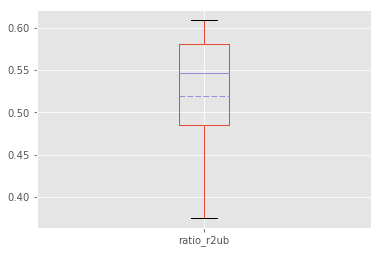

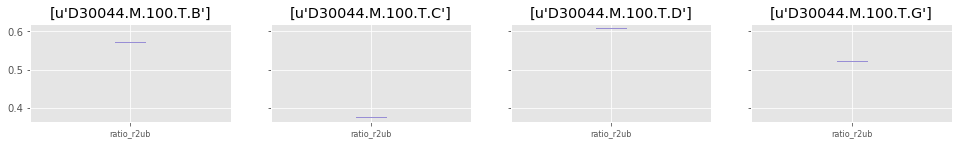

In [48]:
delta2 = data.loc[:,[ dep_var, "ref_summary"]]

delta2.boxplot(figsize=(10,4), showmeans=True, meanline=True, sym="+", vert=True)

delta2.groupby("ref_summary").boxplot(figsize=(16,4), layout=(2,4), fontsize="8", showmeans=True, meanline=True, sym="+", vert=True)
plt.savefig(path.join(basepath, "%s-%s-%s-per-summary-%s.pdf" % ("boxplot", selected_classtype, dep_var, "ref_summary")))

plt.show()
plt.close()
#indep_var = ["ref_summary"]

Block 2: SimpleNgramFeedbackGraph
---

In [49]:
selected_classtype = "SimpleNgramFeedbackGraph"

This feedback store has three parameters.
The following combinations are tested:

In [50]:
indep_var = [ "multiplier_accept","multiplier_reject", "window_size"]

                window_size = [2, 3, 4, 5]
                factor_rejects = [1, 0, 0.05, 0.25, 0.5, 2, 4,8]
                factor_accepts = [1, 0, 0.05, 0.25, 0.5, 2, 4,8]

As a result, there are `4*7*7 = 196` combinations per topic. In total, there should be `196 * 4` resp. `196 * 8` rows in the dataset

In [51]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [52]:
len(data)

1024

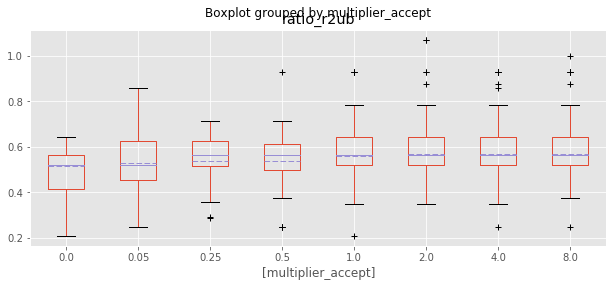

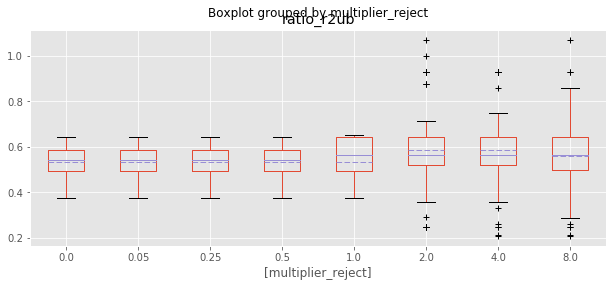

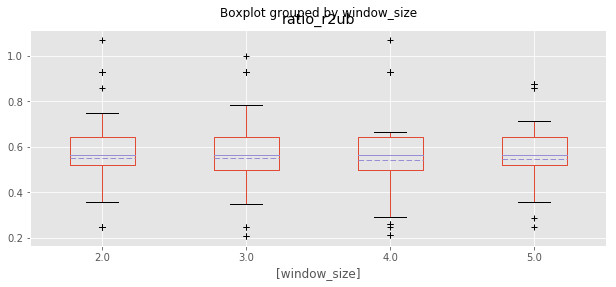

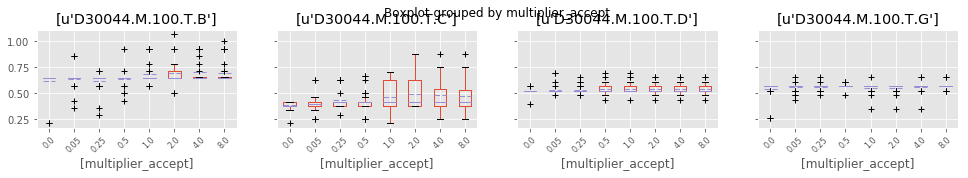

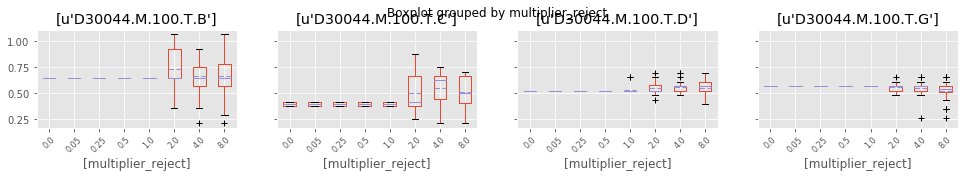

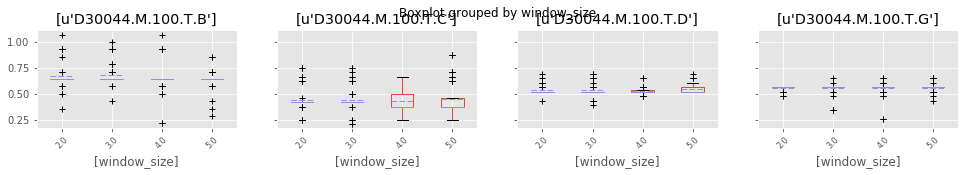

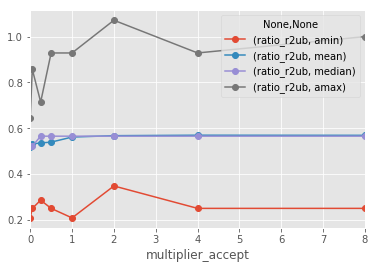

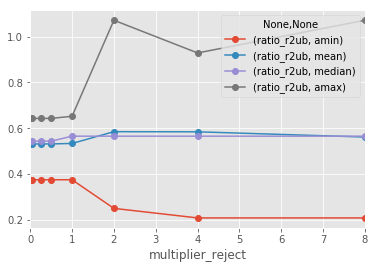

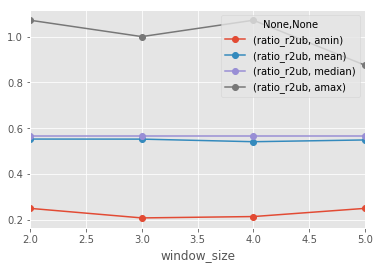

In [53]:
for col in indep_var:
    bp(data, col, dep_var,classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="groupby", classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="line", classtype=selected_classtype)


Block 3: WordEmbeddingGaussianFeedbackGraph
---

In [55]:
selected_classtype = "WordEmbeddingGaussianFeedbackGraph"

In [56]:
# indep_var = [ "mass_accept","mass_reject","type","iterations_accept","iterations_reject", "cutoff_threshold"]
# due to a bug, the cutoff_threshold is NOT stored in the result file, we therefore have to exclude it.
indep_var = [ "mass_accept","mass_reject","type","iterations_accept","iterations_reject"]

                mass_reject = [4.0, 1.0, 0.0, -1.0, -4.0]
                mass_accept = [4.0, 1.0, 0.0, -1.0, -4.0]
                iterations_accept = [16, 128, 1024]
                iterations_reject = [2, 4, 8, 16, 64]
                cut_off_threshold = [0.998, 0.98, 0.9, 0.6, 0.4]

Results in 1875 combinations per topic.

In [57]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [58]:
len(data)

4695

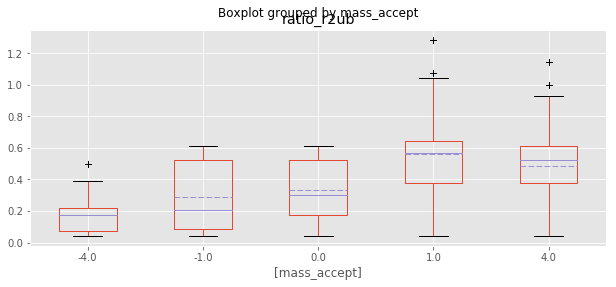

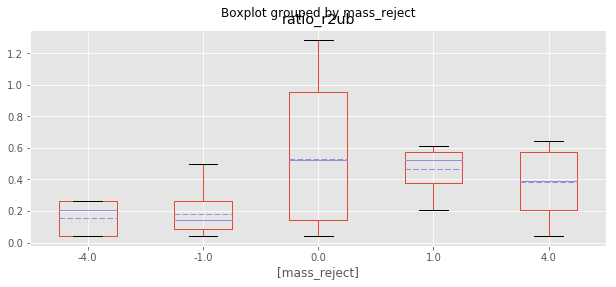

problem while plotting  type ratio_r2ub


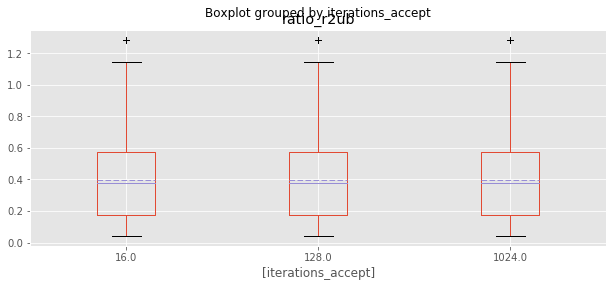

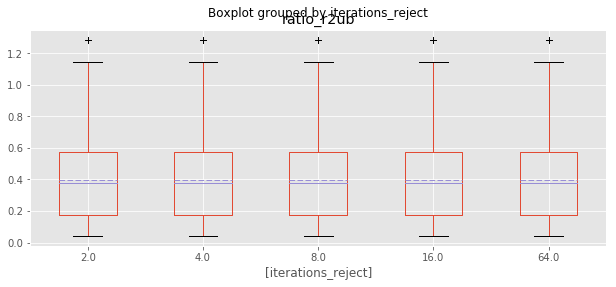

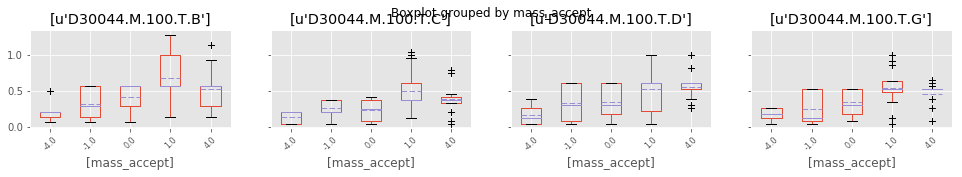

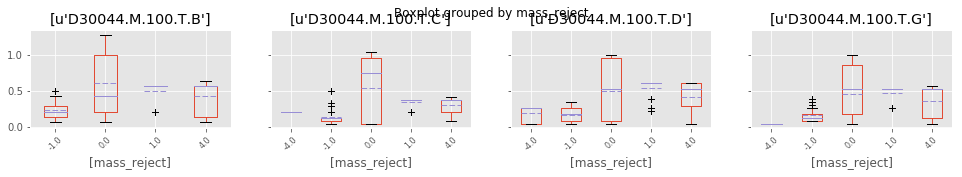

problem while plotting  type ratio_r2ub


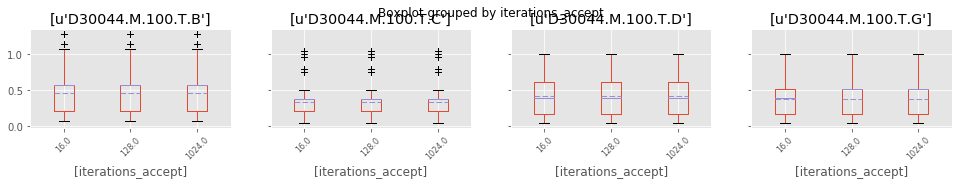

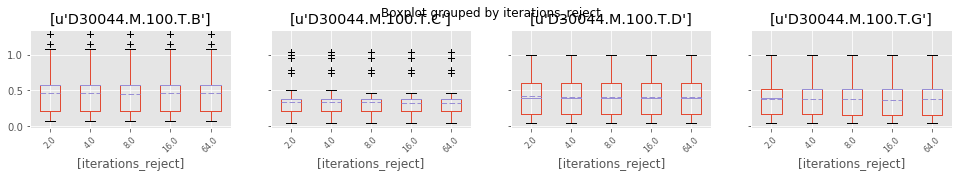

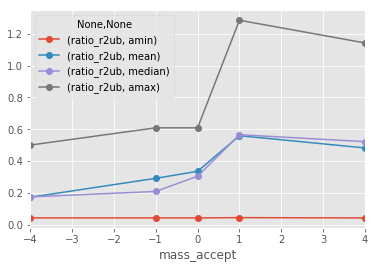

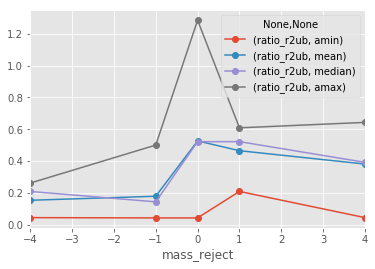

problem while plotting  type ratio_r2ub


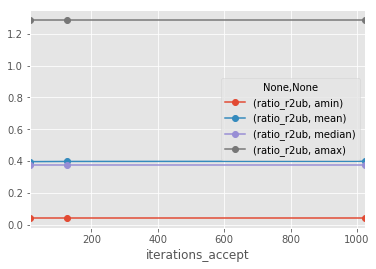

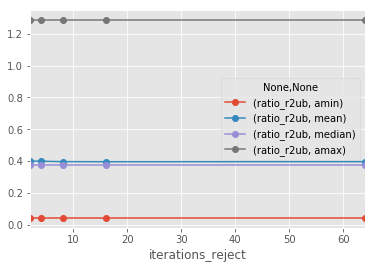

In [59]:
for col in indep_var:
    bp(data, col, dep_var,classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="groupby", classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="line", classtype=selected_classtype)


Block 4: WordEmbeddingRandomWalkDiffusionFeedbackGraph
---

In [60]:
selected_classtype = "WordEmbeddingRandomWalkDiffusionFeedbackGraph"

This feedback store has 6 parameters.
The following combinations are tested:

In [61]:
indep_var = [ "mass_reject", "mass_accept", \
             "iterations_accept", "iterations_reject",\
             "propagation_abort_threshold", \
             "cutoff_threshold"]

                mass_reject = [4.0, 1.0, 0.0, -1.0, -4.0]
                mass_accept = [4.0, 1.0, 0.0, -1.0, -4.0]
                iterations_accept = [128, 1024, 10000]
                iterations_reject = [64, 200, 5000]
                cut_off_threshold = [0.998, 0.98, 0.9, 0.6, 0.4]
                propagation_abort_threshold = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]


As a result, there are `5*5*3*3*5*6 = 6750` combinations per topic. In total, there should be `6750 * 4` resp. `6750 * 8` rows in the dataset

In [62]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [63]:
len(data)

26979

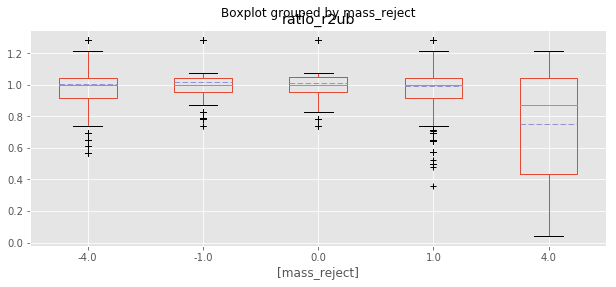

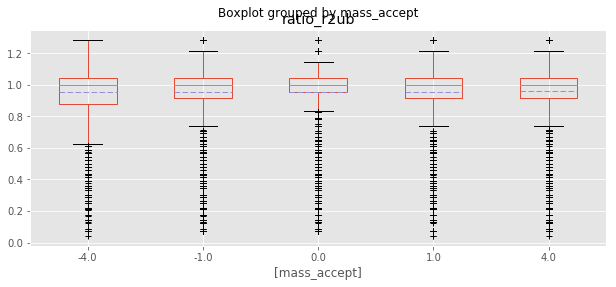

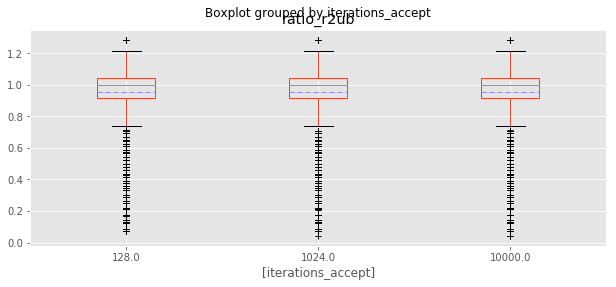

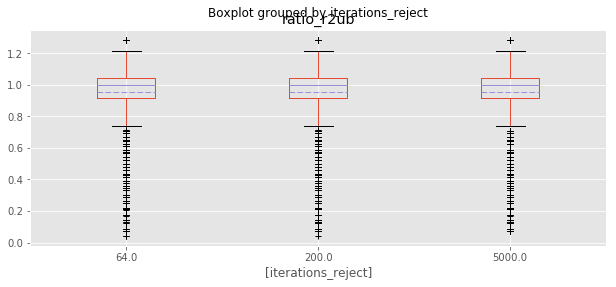

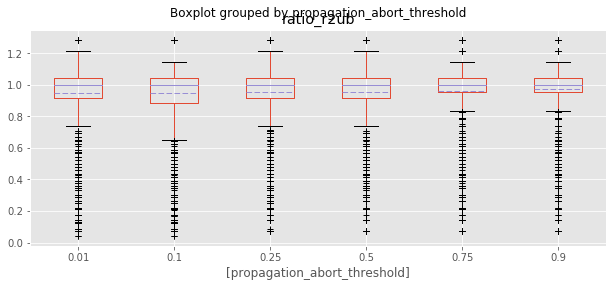

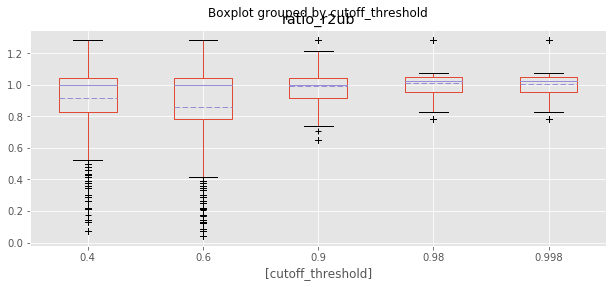

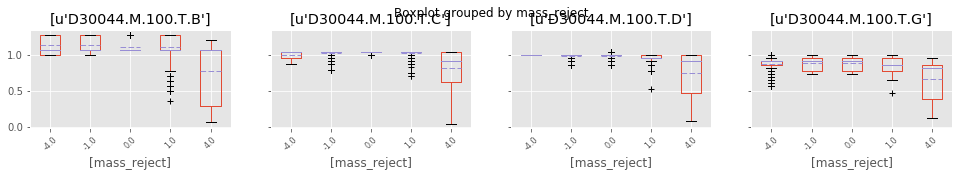

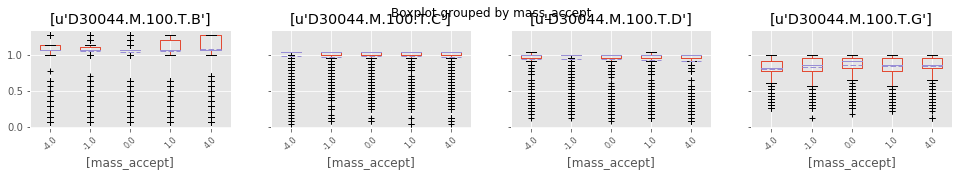

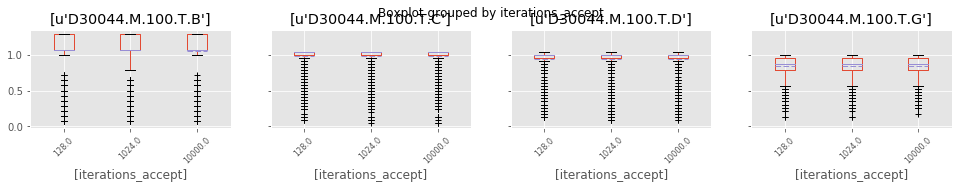

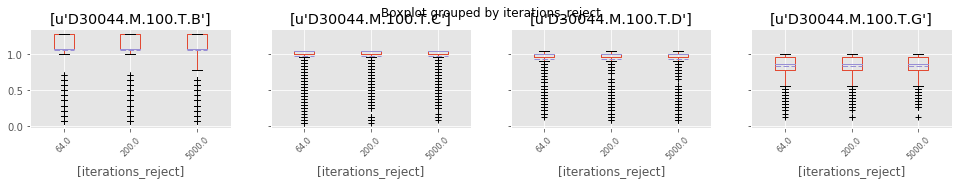

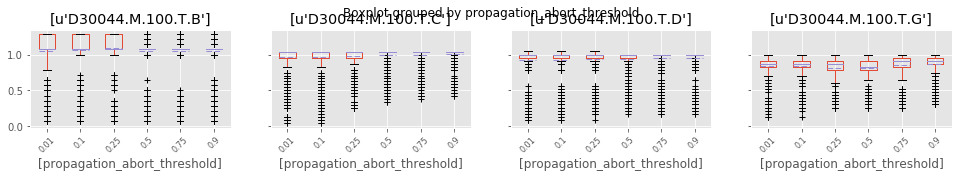

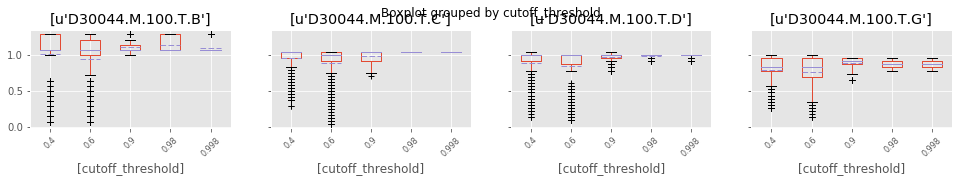

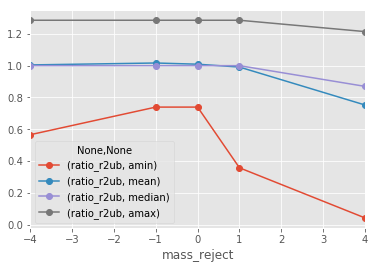

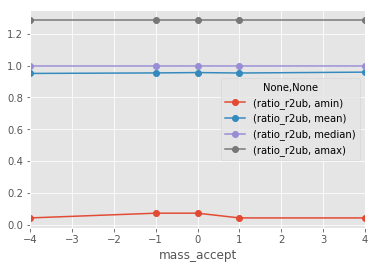

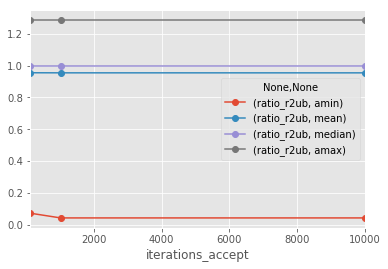

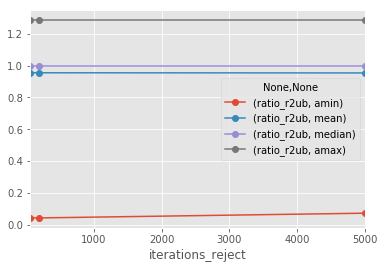

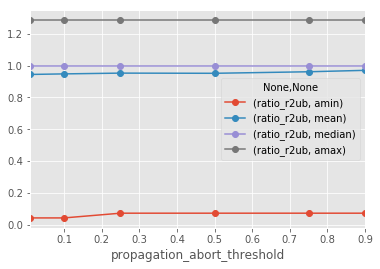

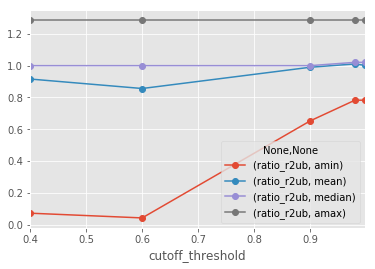

In [64]:
for col in indep_var:
    bp(data, col, dep_var,classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="groupby", classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="line", classtype=selected_classtype)


Some overall basic correlation tests
===

In [65]:
df.corr(method="spearman")


,accept,cutoff_threshold,iterations_accept,iterations_reject,mass_accept,mass_reject,max_iteration_count,multiplier_accept,multiplier_reject,num_iterations,...,ub_r4,window_size,acceptbl,rejectbl,r2bl,delta_r2bl_r2,ratio_r2bl_r2,delta_r2ub,ratio_r2ub,ratio_r2ub_vs_feedback
accept,1.000000,-0.015802,0.101529,0.171288,2.568740e-02,0.179979,NaN,0.038094,0.711405,0.736855,...,0.397309,0.118370,0.372415,-0.372415,0.372415,-0.153711,-0.037121,0.134817,-0.215917,-0.672401
cutoff_threshold,-0.015802,1.000000,-0.023727,-0.039141,-4.005946e-04,-0.024790,NaN,NaN,NaN,-0.013445,...,-0.001342,NaN,-0.001672,0.001672,-0.001672,-0.048946,0.067289,-0.092501,0.095294,-0.029203
iterations_accept,0.101529,-0.023727,1.000000,0.215230,-2.472775e-02,-0.052214,NaN,NaN,NaN,0.069753,...,0.000971,NaN,-0.005757,0.005757,-0.005757,-0.187270,0.187815,-0.191307,0.191140,0.014437
iterations_reject,0.171288,-0.039141,0.215230,1.000000,-4.130012e-02,-0.086984,NaN,NaN,NaN,0.119500,...,0.001884,NaN,-0.009290,0.009290,-0.009290,-0.310531,0.310005,-0.315794,0.316023,0.019193
mass_accept,0.025687,-0.000401,-0.024728,-0.041300,1.000000e+00,0.011734,NaN,NaN,NaN,0.019601,...,0.002271,NaN,-0.001678,0.001678,-0.001678,-0.016225,-0.000701,0.012694,-0.016153,0.028760
mass_reject,0.179979,-0.024790,-0.052214,-0.086984,1.173417e-02,1.000000,NaN,NaN,NaN,0.086595,...,-0.001180,NaN,-0.000827,0.000827,-0.000827,0.298880,-0.253875,0.270193,-0.259365,-0.229769
max_iteration_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
multiplier_accept,0.038094,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.087677,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.115421,0.106289,-0.102212,0.127802,-0.019682
multiplier_reject,0.711405,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.841911,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.085271,0.073558,-0.137148,0.140123,-0.710342
num_iterations,0.736855,-0.013445,0.069753,0.119500,1.960087e-02,0.086595,NaN,0.087677,0.841911,1.000000,...,0.414815,0.075367,0.322797,-0.322797,0.322797,-0.061787,-0.131371,0.364560,-0.424732,-0.858857


In [66]:
df.corr(method="pearson").to_csv(path.join(basepath, "correlation-analysis-pearson-overall.csv"))


In [67]:
df.groupby("classtype").corr(method="pearson").to_csv(path.join(basepath, "correlation-analysis-pearson-per-classtype.csv"))


In [68]:
cols = list(df.columns)

In [69]:
cols = list(set(cols) - set(['accept', 'num_iterations', 'r1', 'r2', 'r4', 'reject', 'total_feedback', 'ub_r1', 'ub_r2', 'ub_r4', 'acceptbl', 'rejectbl', 'r2bl', 'delta_r2bl_r2', 'ratio_r2bl_r2', 'delta_r2ub']))

In [70]:
r= df.loc[:,cols].groupby(["classtype", "mass_accept"]).corr(method="pearson")

r.to_csv(path.join(basepath, "correlation-analysis-pearson-per-classtype-and-mass_accept.csv"))
r

cutoff_threshold  \
classtype                                     mass_accept                                                 
WordEmbeddingGaussianFeedbackGraph            -4.0        cutoff_threshold                 1.000000e+00   
                                                          iterations_accept               -8.472821e-17   
                                                          iterations_reject               -3.104362e-04   
                                                          mass_reject                     -6.178589e-01   
                                                          max_iteration_count                       NaN   
                                                          multiplier_accept                         NaN   
                                                          multiplier_reject                         NaN   
                                                          propagation_abort_threshold               NaN   
                                                          ratio_r2ub                      -1.052391e-01   
                                                          ratio_r2ub_vs_feedback          -3.667985e-01   
                                                          size                                      NaN   
                                                          window_size                               NaN   
                                              -1.0        cutoff_threshold                 1.000000e+00   
                                                          iterations_accept               -4.643585e-18   
                                                          iterations_reject               -2.299472e-03   
                                                          mass_reject                     -4.681804e-01   
                                                          max_iteration_count                       NaN   
                                                          multiplier_accept                         NaN   
                                                          multiplier_reject                         NaN   
                                                          propagation_abort_threshold               NaN   
                                                          ratio_r2ub                      -2.167164e-01   
                                                          ratio_r2ub_vs_feedback          -2.710360e-01   
                                                          size                                      NaN   
                                                          window_size                               NaN   
                                               0.0        cutoff_threshold                 1.000000e+00   
                                                          iterations_accept                1.007876e-17   
                                                          iterations_reject                3.094092e-17   
                                                          mass_reject                     -3.263291e-01   
                                                          max_iteration_count                       NaN   
                                                          multiplier_accept                         NaN   
...                                                                                                 ...   
WordEmbeddingRandomWalkDiffusionFeedbackGraph  0.0        multiplier_reject                         NaN   
                                                          propagation_abort_threshold     -7.073838e-05   
                                                          ratio_r2ub                       2.594200e-01   
                                                          ratio_r2ub_vs_feedback           7.094193e-02   
                                                          size                                      NaN   
                     

Top result analysis
===

From the best performing summaries, are there certain configurations that appear more often than others?

in the first run, we use the `WordEmbeddingRandomWalkDiffusionFeedbackGraph`

In [71]:
selected_classtype = "WordEmbeddingRandomWalkDiffusionFeedbackGraph"

In [72]:
data = df.loc[df.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")]

In [73]:
d = data.loc[df.ratio_r2ub > 1.0, ["classtype","cutoff_threshold","iterations_accept","iterations_reject","mass_accept","mass_reject","propagation_abort_threshold", "ref_summary","ratio_r2ub"]]

[u'D30044.M.100.T.D'] classtype                      19
cutoff_threshold               19
iterations_accept              19
iterations_reject              19
mass_accept                    19
mass_reject                    19
propagation_abort_threshold    19
ref_summary                    19
ratio_r2ub                     19
dtype: int64


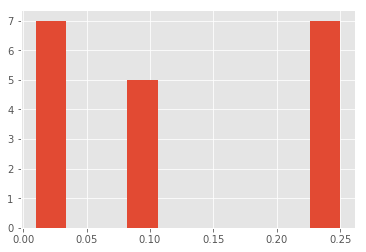

[u'D30044.M.100.T.C'] classtype                      4960
cutoff_threshold               4960
iterations_accept              4960
iterations_reject              4960
mass_accept                    4960
mass_reject                    4960
propagation_abort_threshold    4960
ref_summary                    4960
ratio_r2ub                     4960
dtype: int64


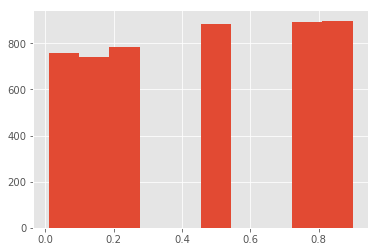

[u'D30044.M.100.T.B'] classtype                      5604
cutoff_threshold               5604
iterations_accept              5604
iterations_reject              5604
mass_accept                    5604
mass_reject                    5604
propagation_abort_threshold    5604
ref_summary                    5604
ratio_r2ub                     5604
dtype: int64


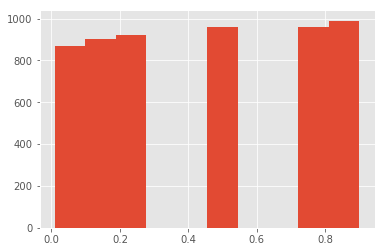

In [74]:
g = d.groupby("ref_summary")
for grp in g.groups:
    print grp, g.get_group(grp).count()
    
    g.get_group(grp)["propagation_abort_threshold"].hist()
    plt.show()


C:\bin\anaconda\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


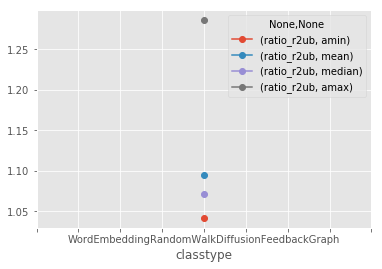

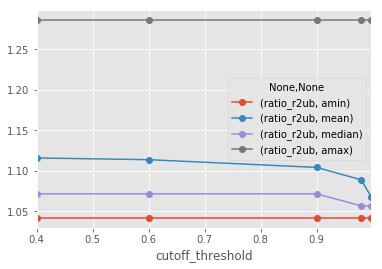

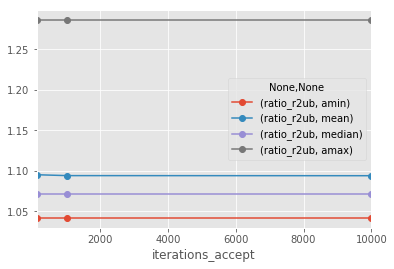

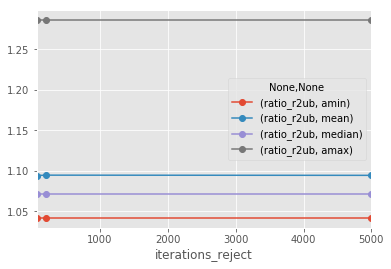

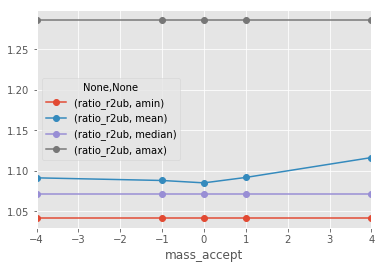

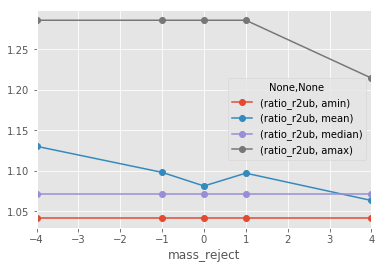

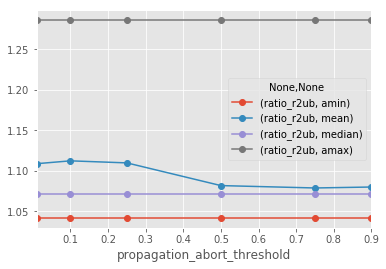

problem while plotting  ref_summary ratio_r2ub


In [75]:
for col in d.columns:
    if col is not dep_var:
        bp(d, col, dep_var, grouping="line")

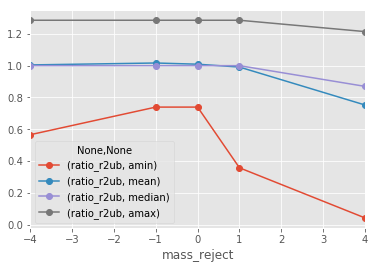

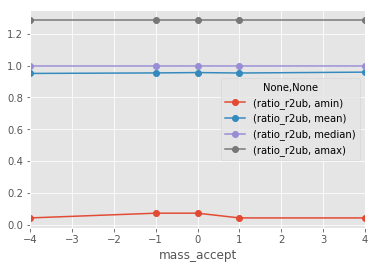

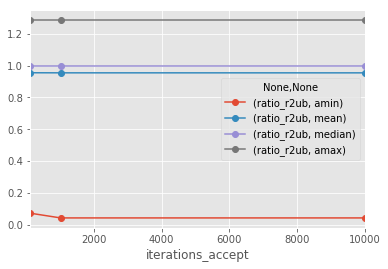

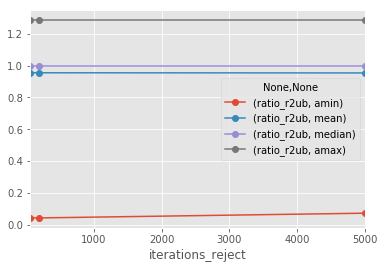

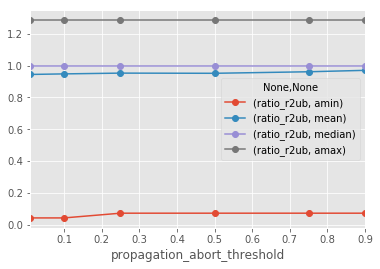

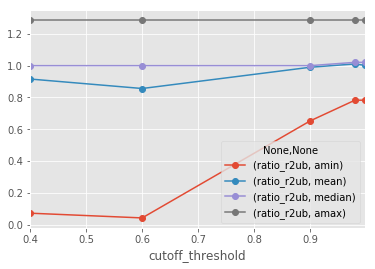

In [76]:
for col in indep_var:
    bp(data, col, dep_var, grouping="line")
    

Display all configurations in one single giant plot with r2ub vs feedbacks
===

In [77]:
data = df

In [78]:
data.plot.scatter(x='ratio_r2ub', y='total_feedback');

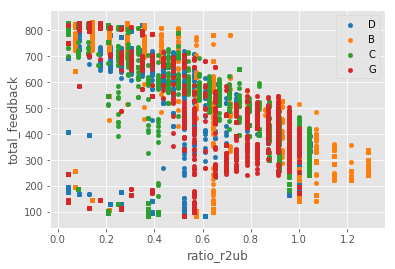

In [126]:
ax = data.loc[df.ref_summary.str.contains("D30044.M.100.T.D")].plot.scatter(x='ratio_r2ub', y='total_feedback', color=plt.get_cmap("Vega10").colors[0], label='D');
bx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.B")].plot.scatter(x='ratio_r2ub', y='total_feedback', color=plt.get_cmap("Vega10").colors[1], label='B',ax=ax)
cx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.C")].plot.scatter(x='ratio_r2ub', y='total_feedback', color=plt.get_cmap("Vega10").colors[2], label='C',ax=ax)
dx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.G")].plot.scatter(x='ratio_r2ub', y='total_feedback', color=plt.get_cmap("Vega10").colors[3], label='G',ax=ax)
plt.show()

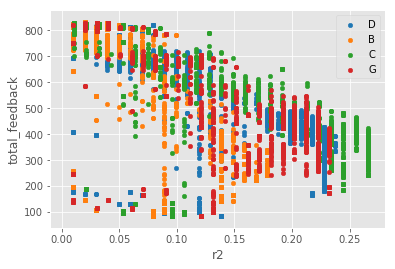

In [127]:
ax = data.loc[df.ref_summary.str.contains("D30044.M.100.T.D")].plot.scatter(x='r2', y='total_feedback', color=plt.get_cmap("Vega10").colors[0], label='D');
bx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.B")].plot.scatter(x='r2', y='total_feedback', color=plt.get_cmap("Vega10").colors[1], label='B',ax=ax)
cx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.C")].plot.scatter(x='r2', y='total_feedback', color=plt.get_cmap("Vega10").colors[2], label='C',ax=ax)
dx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.G")].plot.scatter(x='r2', y='total_feedback', color=plt.get_cmap("Vega10").colors[3], label='G',ax=ax)
plt.show()

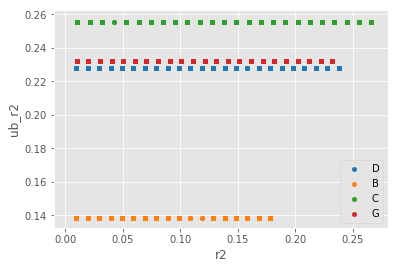

In [128]:
ax = data.loc[df.ref_summary.str.contains("D30044.M.100.T.D")].plot.scatter(x='r2', y='ub_r2', color=plt.get_cmap("Vega10").colors[0], label='D');
bx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.B")].plot.scatter(x='r2', y='ub_r2', color=plt.get_cmap("Vega10").colors[1], label='B',ax=ax)
cx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.C")].plot.scatter(x='r2', y='ub_r2', color=plt.get_cmap("Vega10").colors[2], label='C',ax=ax)
dx = data.loc[df.ref_summary.str.contains("D30044.M.100.T.G")].plot.scatter(x='r2', y='ub_r2', color=plt.get_cmap("Vega10").colors[3], label='G',ax=ax)
plt.show()

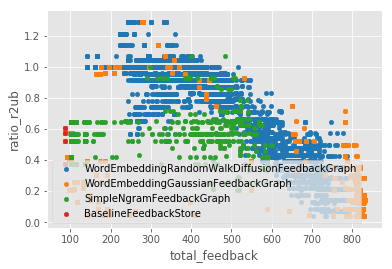

In [129]:
ax = data.loc[df.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")].plot.scatter(x='total_feedback', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[0], label='WordEmbeddingRandomWalkDiffusionFeedbackGraph');
bx = data.loc[df.classtype.str.contains("WordEmbeddingGaussianFeedbackGraph")].plot.scatter(x='total_feedback', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[1], label='WordEmbeddingGaussianFeedbackGraph',ax=ax)
cx = data.loc[df.classtype.str.contains("SimpleNgramFeedbackGraph")].plot.scatter(x='total_feedback', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[2], label='SimpleNgramFeedbackGraph',ax=ax)
dx = data.loc[df.classtype.str.contains("BaselineFeedbackStore")].plot.scatter(x='total_feedback', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[3], label='BaselineFeedbackStore',ax=ax)
plt.show()

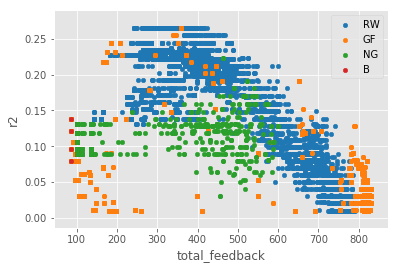

In [130]:
ax = data.loc[df.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")].plot.scatter(x='total_feedback', y='r2', color=plt.get_cmap("Vega10").colors[0], label='RW');
bx = data.loc[df.classtype.str.contains("WordEmbeddingGaussianFeedbackGraph")].plot.scatter(x='total_feedback', y='r2', color=plt.get_cmap("Vega10").colors[1], label='GF',ax=ax)
cx = data.loc[df.classtype.str.contains("SimpleNgramFeedbackGraph")].plot.scatter(x='total_feedback', y='r2', color=plt.get_cmap("Vega10").colors[2], label='NG',ax=ax)
dx = data.loc[df.classtype.str.contains("BaselineFeedbackStore")].plot.scatter(x='total_feedback', y='r2', color=plt.get_cmap("Vega10").colors[3], label='B',ax=ax)
plt.show()

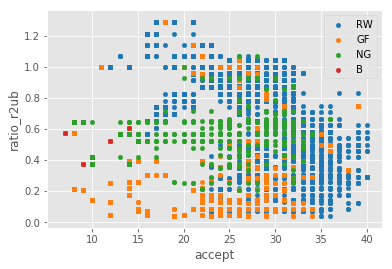

In [131]:
ax = data.loc[df.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")].plot.scatter(x='accept', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[0], label='RW');
bx = data.loc[df.classtype.str.contains("WordEmbeddingGaussianFeedbackGraph")].plot.scatter(x='accept', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[1], label='GF',ax=ax)
cx = data.loc[df.classtype.str.contains("SimpleNgramFeedbackGraph")].plot.scatter(x='accept', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[2], label='NG',ax=ax)
dx = data.loc[df.classtype.str.contains("BaselineFeedbackStore")].plot.scatter(x='accept', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[3], label='B',ax=ax)
plt.show()

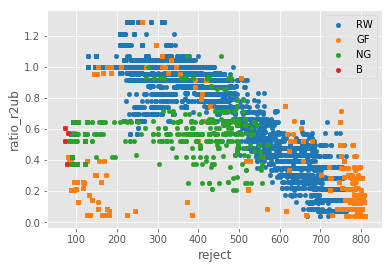

In [132]:
ax = data.loc[df.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")].plot.scatter(x='reject', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[0], label='RW');
bx = data.loc[df.classtype.str.contains("WordEmbeddingGaussianFeedbackGraph")].plot.scatter(x='reject', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[1], label='GF',ax=ax)
cx = data.loc[df.classtype.str.contains("SimpleNgramFeedbackGraph")].plot.scatter(x='reject', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[2], label='NG',ax=ax)
dx = data.loc[df.classtype.str.contains("BaselineFeedbackStore")].plot.scatter(x='reject', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[3], label='B',ax=ax)
plt.show()

In [118]:
plt.get_cmap("Vega10").colors[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [117]:
m.colors[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

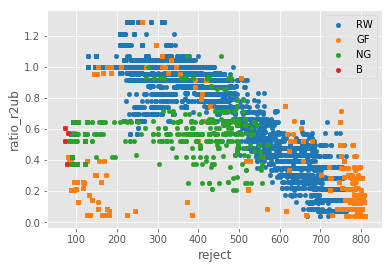

In [139]:
ax = data.loc[df.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")].plot.scatter(x='reject', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[0], label='RW',ax=None);
ax = data.loc[df.classtype.str.contains("WordEmbeddingGaussianFeedbackGraph")].plot.scatter(x='reject', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[1], label='GF', ax=ax)
ax = data.loc[df.classtype.str.contains("SimpleNgramFeedbackGraph")].plot.scatter(x='reject', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[2], label='NG', ax=ax)
ax = data.loc[df.classtype.str.contains("BaselineFeedbackStore")].plot.scatter(x='reject', y='ratio_r2ub', color=plt.get_cmap("Vega10").colors[3], label='B', ax=ax)
plt.show()

In [145]:
def scatterplot(data, locs, x='ratio_r2ub',y='total_feedback'):
    ax= None
    for i in range(len(locs)):
        l = locs[i]
        c = plt.get_cmap("Vega10").colors[i];
        ax = data.loc[l].plot.scatter(x=x, y=y, color=c, ax=ax);
    plt.show()

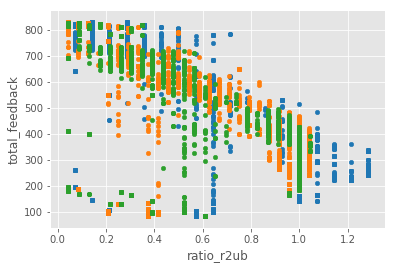

In [146]:
scatterplot(df, [df.ref_summary.str.contains("D30044.M.100.T.B"),df.ref_summary.str.contains("D30044.M.100.T.C"),df.ref_summary.str.contains("D30044.M.100.T.D")])

In [147]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [148]:
range(1,10)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [151]:
data.loc[df.classtype.str.contains("SimpleNgramFeedbackGraph")].agg(np.count)

AttributeError: 'DataFrame' object has no attribute 'agg'